In [2]:
from torch import nn
import torch
from torch.optim import AdamW
import numpy as np
import re
from nltk.tokenize import word_tokenize
import wikipediaapi
import matplotlib.pyplot as plt

In [11]:


def generate_data_skipgram(corpus, window_size, vocab_size, word_to_index):
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    # Input word as index
                    all_in.append(word_to_index[word])
                    # Context word as one-hot
                    one_hot = np.zeros(vocab_size)
                    one_hot[word_to_index[words[i]]] = 1
                    all_out.append(one_hot)

    return np.array(all_in), np.array(all_out)

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.out = nn.Linear(embedding_dim, vocab_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        emb = self.embedding(x)
        out = self.out(emb)
        return self.softmax(out)


# Initialize the Wikipedia API for Finnish
user_agent = "YourAppName/1.0 (your.email@example.com)"
wiki = wikipediaapi.Wikipedia(language="en", user_agent=user_agent)

def get_category_members(category_name, max_pages=10):
    category = wiki.page("Category:" + category_name)
    if not category.exists():
        print(f"Category '{category_name}' does not exist.")
        return []

    articles = []
    for member in category.categorymembers.values():
        if len(articles) >= max_pages:
            break
        if member.ns == 0:  # ns=0 indicates articles
            print(f"Fetching: {member.title}")
            articles.append(member.text)
    return articles

# Example: Fetch articles from the "Tekniikka" (Technology) category
finnish_articles = get_category_members("Biology", max_pages=30)



Fetching: History
Fetching: Glossary of history
Fetching: Outline of history
Fetching: Art and culture law
Fetching: Biography
Fetching: List of historical classifications
Fetching: Environmental history
Fetching: Historical figure
Fetching: Historical culture
Fetching: Historical significance
Fetching: Historicism
Fetching: Local history
Fetching: History of magic
Fetching: National memory


In [12]:
def clean_wikipedia_text(text):
    text = re.sub(r"=+.*?=+", "", text)
    
    # Remove references like [1], [2]
    text = re.sub(r"\[\d+\]", "", text)
    
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    
    # Remove links (URLs)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    
    # Remove sections that are non-informative
    sections = ["See also", "References", "External links", "Further reading", "Katso myös", "Viitteet", "Lähteet"]
    for section in sections:
        text = re.sub(rf"== {section} ==.*", "", text, flags=re.DOTALL)

    # Remove special characters and numbers (retain only alphabetic characters and spaces)
    text = re.sub(r"[^a-zA-ZäöåÄÖÅ\s]", "", text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Clean all articles
corpus = [clean_wikipedia_text(article) for article in finnish_articles]
print(f"Cleaned {len(corpus)} articles.")

# Filter short sentences
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

# Tokenize corpus into words
corpus = [word_tokenize(sentence.lower()) for sentence in corpus]

# Build vocabulary and word-to-index mapping
flat_corpus = [word for sentence in corpus for word in sentence]
unique_words = sorted(set(flat_corpus))
word_to_index = {word: idx for idx, word in enumerate(unique_words)}
vocab_size = len(unique_words)


# Generate skip-gram data
window_size = 3
X_skip, y_skip = generate_data_skipgram(corpus, window_size, vocab_size, word_to_index)
print(f"Input shape: {X_skip.shape}, Output shape: {y_skip.shape}")


Cleaned 14 articles.


: 

: 

In [5]:
vocab_size

8976

In [6]:
list(word_to_index)[:100]

['a',
 'aa',
 'ab',
 'aba',
 'abandon',
 'abandonment',
 'abano',
 'abbreviated',
 'abbreviation',
 'abcclio',
 'abd',
 'aberrational',
 'abilities',
 'ability',
 'ablainen',
 'able',
 'abolish',
 'aboriginal',
 'about',
 'above',
 'abracadabra',
 'abrahadabra',
 'abraham',
 'abramelin',
 'abridgement',
 'absence',
 'absent',
 'absolute',
 'absolutism',
 'absorbed',
 'abstract',
 'abstraction',
 'abstractions',
 'abstracts',
 'abundance',
 'abyss',
 'ac',
 'academia',
 'academic',
 'academica',
 'academics',
 'academy',
 'accademia',
 'accelerate',
 'accelerated',
 'accelerating',
 'accent',
 'accentuation',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'access',
 'accessed',
 'accessible',
 'accompanied',
 'accompany',
 'accompanying',
 'accomplished',
 'accomplishments',
 'accord',
 'accordance',
 'according',
 'accordingly',
 'account',
 'accounted',
 'accounts',
 'accrual',
 'accumulate',
 'accumulated',
 'accumulation',
 'accuracy',
 'accurate',
 'accurately',
 'accusatio

In [7]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the Word2Vec model
embedding_dim = 200
batch_size = 32
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.to(device)
optim = AdamW(word2vec.parameters(), lr=0.001)
loss_f = nn.CrossEntropyLoss()

# Convert data to PyTorch tensors
X_skip = torch.tensor(X_skip, dtype=torch.long, device=device)  # Input indices
y_skip = torch.tensor(y_skip, dtype=torch.float, device=device)  # One-hot encoded targets

# Training loop

In [8]:
losses = []
iters = 5000
norm_losses = []
for i in range(1, iters+1):  # Number of training steps
    # Randomly sample a batch of data
    
    idx = np.random.choice(len(X_skip), size=batch_size, replace=True)
    
    batch_x, batch_y = X_skip[idx], y_skip[idx]

    # Zero gradients from the previous step
    optim.zero_grad()

    # Forward pass
    out = word2vec(batch_x)

    # Compute the loss
    loss = loss_f(out, batch_y)  # Convert one-hot to class indices

    # Backward pass and optimization
    loss.backward()
    optim.step()
    norm_losses.append(loss.item())

    # Print loss every 10 iterations
    if i % 300 == 0:
        avg_loss = sum(norm_losses) / 300
        losses.append(avg_loss)
        print(f"Iteration {i}, Loss: {avg_loss}")
        norm_losses = []

Iteration 300, Loss: 9.09385178565979
Iteration 600, Loss: 9.084591840108235
Iteration 900, Loss: 9.078716071446737
Iteration 1200, Loss: 9.07412210146586
Iteration 1500, Loss: 9.06863834698995
Iteration 1800, Loss: 9.062742214202881
Iteration 2100, Loss: 9.059538742701212
Iteration 2400, Loss: 9.057269458770753
Iteration 2700, Loss: 9.054224809010824
Iteration 3000, Loss: 9.049404344558717
Iteration 3300, Loss: 9.045489533742268
Iteration 3600, Loss: 9.040759989420573
Iteration 3900, Loss: 9.045497280756633
Iteration 4200, Loss: 9.043027499516805
Iteration 4500, Loss: 9.042021843592325
Iteration 4800, Loss: 9.04309580485026


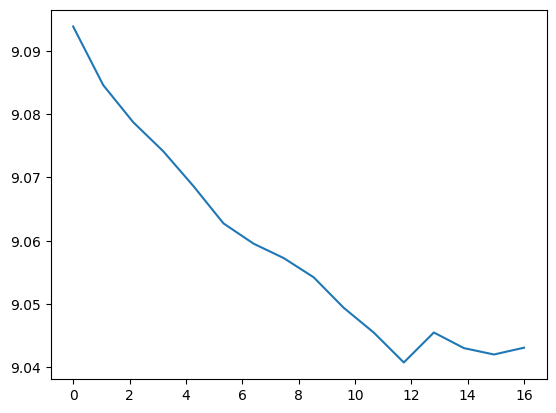

In [9]:
plt.plot(np.linspace(0, len(losses), len(losses)), losses)

In [10]:
torch.save({
    'model_state_dict': word2vec.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'word_to_index': word_to_index,  # Save word-to-index mapping for reuse
}, "word2vec_full_skipgram.pt")
print("Full training state saved as word2vec_full_skipgram.pt")

Full training state saved as word2vec_full_skipgram.pt
